In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.backends.backend_pdf import PdfPages
from utils.vis import temp

temp(20)
# ---------- LOAD ----------
df = pd.read_csv("Worksheet.csv")

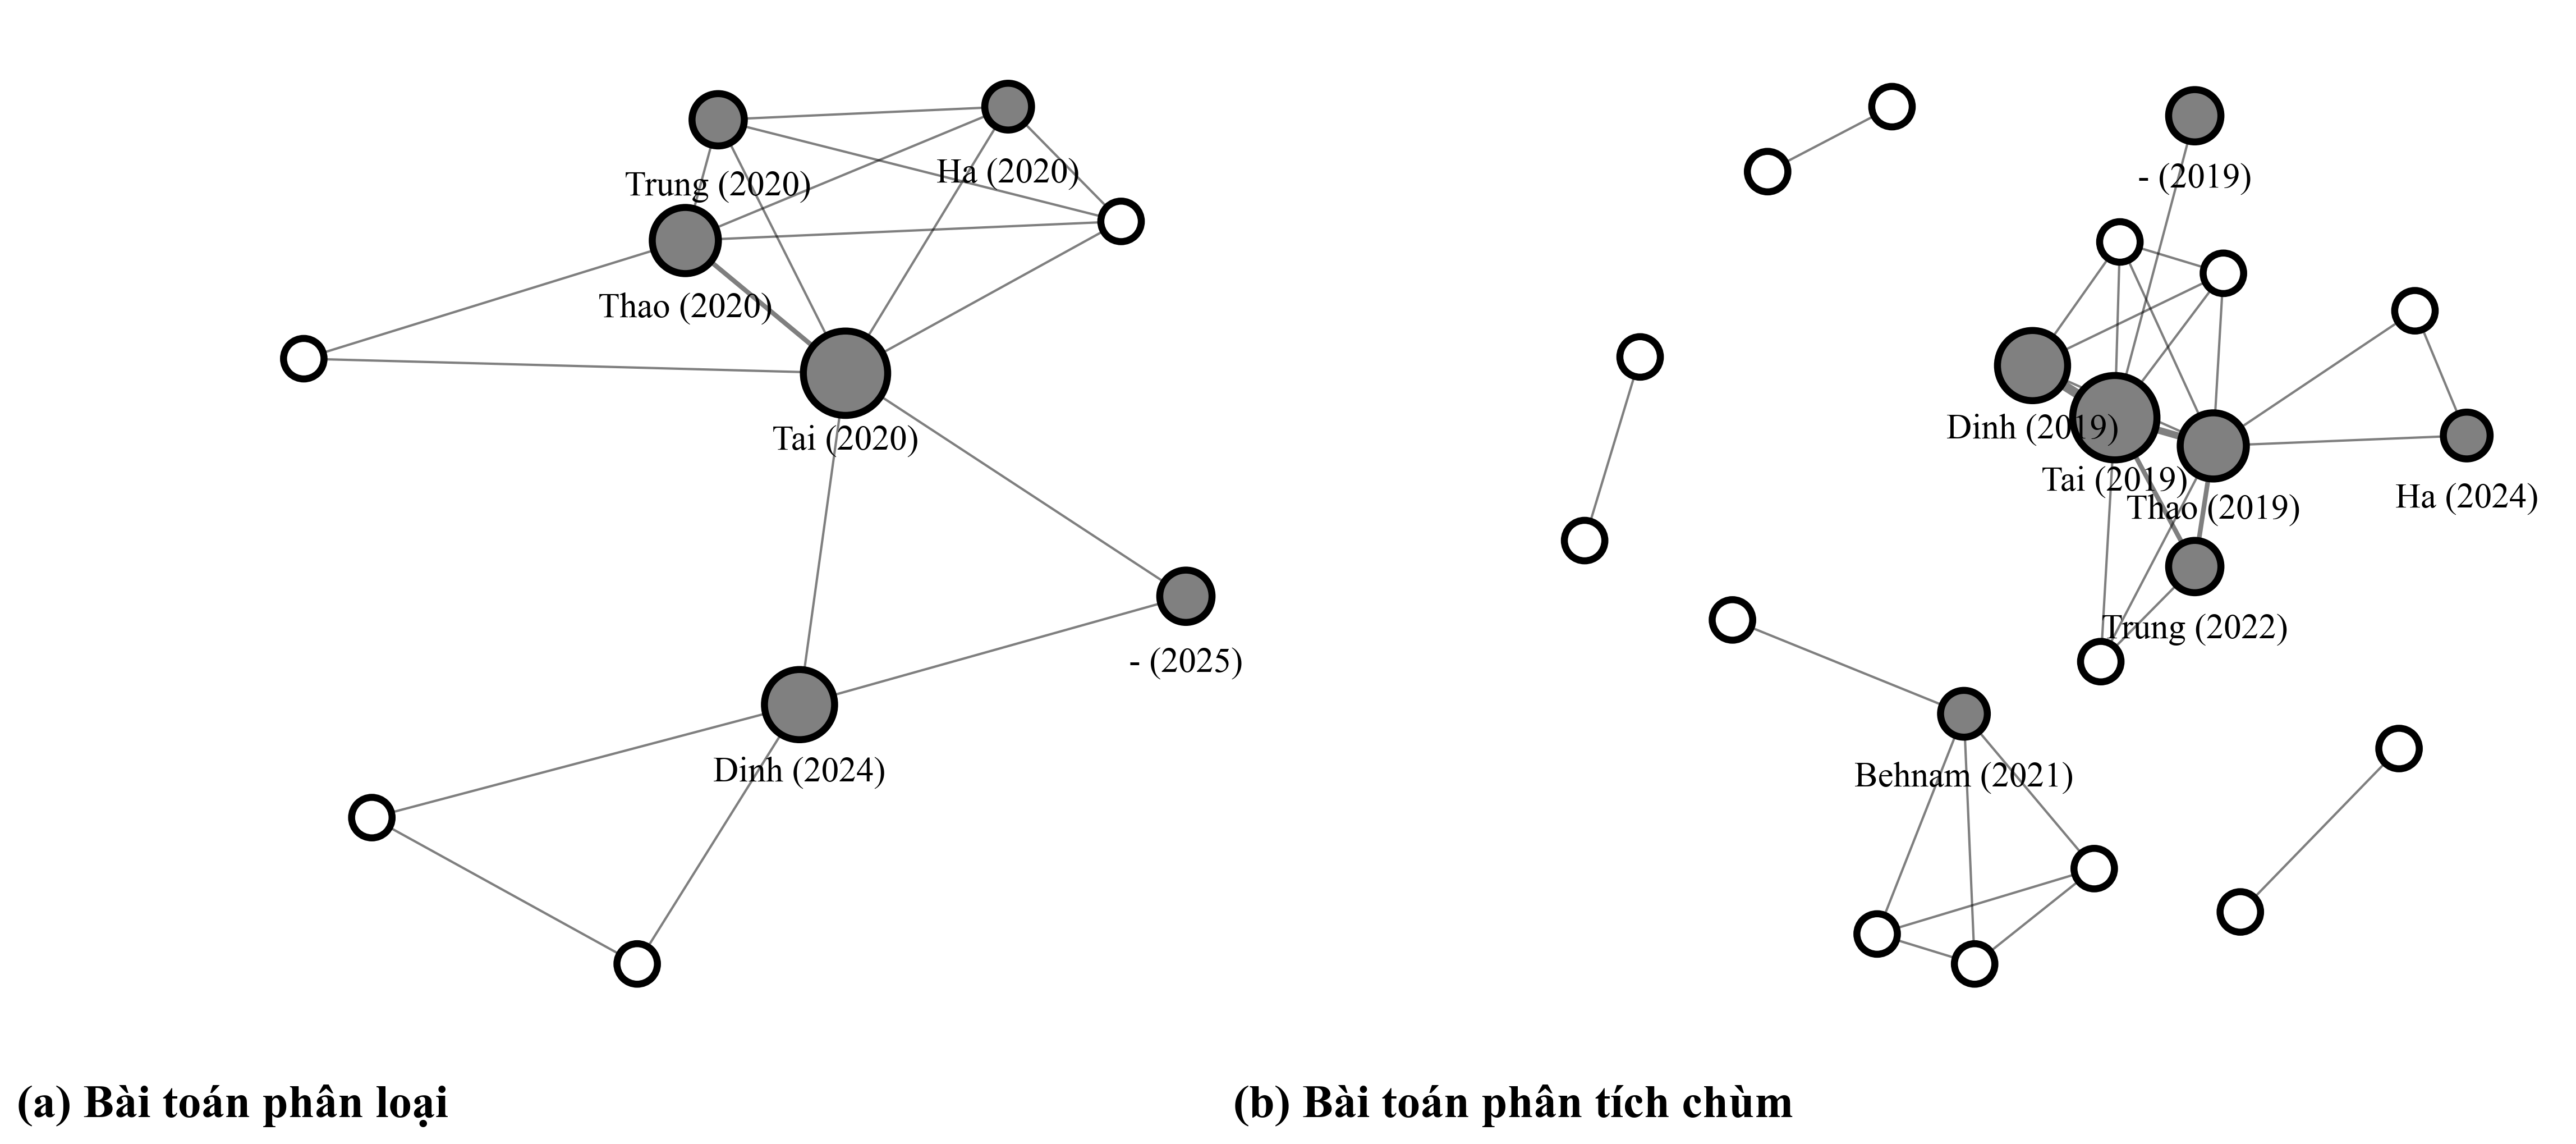

In [3]:
# ---------- 2 FRAME THEO TASK ----------
tasks = sorted(set(df['Task']))
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
task_map = {t: ax for t, ax in zip(tasks, axes)}

# --- màu đơn cho 2 khung ---
colors = {'Unsupervised learning': 'white','Supervised learning': "white", }

for task, ax in task_map.items():
	G = nx.Graph()
	sub = df[df['Task'] == task]
	# thêm node & edge
	for _, r in sub.iterrows():
		authors = [r['Authors']] + [c.strip() for c in str(r['Co-authors']).split(';') if c.strip()]
		for a in authors:
			if a not in G:
					G.add_node(a, year=r['Year'])
		for i in range(len(authors)):
			for j in range(i+1, len(authors)):
					if G.has_edge(authors[i], authors[j]):
						G[authors[i]][authors[j]]['weight'] += 1
					else:
						G.add_edge(authors[i], authors[j], weight=1)

	# layout thưa
	pos = nx.spring_layout(G, k=8, iterations=500, weight='weight')	
	
	# ---------- tính số bài của mỗi tác giả ----------
	pub_count = {}
	for _, r in df.iterrows():
		authors = [r['Authors']] + [c.strip() for c in str(r['Co-authors']).split(';') if c.strip()]
		for a in authors:
			pub_count[a] = pub_count.get(a, 0) + 1

	# ---------- kích thước node ----------

	# vẽ
	nx.draw_networkx_edges(G, pos, ax=ax, width=[d['weight'] for _, _, d in G.edges(data=True)], alpha=0.5)
	nx.draw_networkx_nodes(G, pos, ax=ax,
								node_size=[ 200+100 * (pub_count[n]) for n in G],
								node_color=['gray' if pub_count[n] >= 2 else "white" for n in G],
								edgecolors='black',
								linewidths=3
								)
	# label: "Tên (năm)"
	# ---------- chỉ nhãn khi pub_count ≥ 1 ----------
	labels = {
		n: f"{n.split()[0]} ({G.nodes[n]['year']})"
		if pub_count[n] >= 2              # điều kiện
		else ""                           # bỏ trống
		for n in G
	}
	# Tính offset nhỏ theo hướng dưới-trái
	offset = {n: (0, -0.1) for n in G}   # 0.035 đơn vị trục
	pos_label = {n: (x + dx, y + dy) for n, (x, y) in pos.items() for dx, dy in [offset[n]]}

	nx.draw_networkx_labels(
		G, pos_label, labels=labels, ax=ax,
		font_family='serif', font_size=15,
		verticalalignment='top',
		horizontalalignment='center'
	)
	ax.set_axis_off()
    
	 # Thêm chú thích (a), (b) vào góc trên trái của mỗi khung
	label = '(a) Bài toán phân loại' if task == 'Supervised learning' else '(b) Bài toán phân tích chùm'
	ax.text(0.02, -.05, label, transform=ax.transAxes,
		fontsize=20, fontweight='bold', va='center', ha='center')

# ---------- LƯU PDF ----------
with PdfPages("author_network_task_frames.pdf") as pdf:
   pdf.savefig(fig, bbox_inches='tight')